In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import ipyvolume as ipv
import pandas as pd
import tyssue
from tyssue import Sheet, SheetGeometry as geom
from tyssue import Monolayer, config
from tyssue.io import hdf5
from tyssue.draw import sheet_view
from tyssue.dynamics import model_factory, effectors

%matplotlib inline

print("sys", sys.version)
print("tyssue", tyssue.__version__)


sys 3.7.1 | packaged by conda-forge | (default, Nov 13 2018, 18:15:35) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]
tyssue 0.3.3.dev0+f3289f2


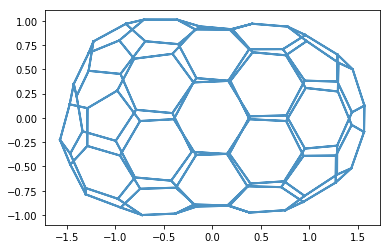

In [2]:
dsets = hdf5.load_datasets('../data/hf5/ellipsoid_sheet.hf5',
                           data_names=['vert', 'edge', 'face'])

sheet = Sheet('ellipse', dsets,
              config.geometry.cylindrical_sheet())

fig, ax = sheet_view(sheet, mode="quick", coords=list('zx'),
                     edge={"lw":2, "alpha":0.8})

In [3]:
sheet.settings['abc'] = 1., 1., 1.5

In [4]:
from tyssue.geometry.sheet_geometry import ClosedSheetGeometry

class EllipsoidGeometry(ClosedSheetGeometry):
    
    @staticmethod
    def update_rho(sheet):
        a, b, c = sheet.settings['abc']
        sheet.vert_df["rho2"] = (  
        (sheet.vert_df.x/a)**2
         + (sheet.vert_df.y/b)**2
         + (sheet.vert_df.z/c)**2)
    
    @classmethod
    def update_all(cls, sheet):
        super().update_all(sheet)
        cls.update_rho(sheet)


class EllipsoidConstraint(effectors.AbstractEffector):
    
    dimensions = None
    magnitude = 'ellipsoid_constraint'
    label = "Ellipsoidal shell sticking constraint"
    element = 'vert'
    specs = {"settings": {"abc": (1., 1., 1.)},
             "vert": {'ellipsoid_constraint': 1.}}
    
    def energy(sheet):
        return sheet.vert_df.eval('ellipsoid_constraint * (rho2 - 1)**2')
    
    def gradient(sheet):
        a, b, c = sheet.settings['abc']
        grad = pd.DataFrame(index=sheet.vert_df.index,
                            columns=['gx', 'gy', 'gz'])
        const = sheet.vert_df.eval(
                f'4*ellipsoid_constraint * (rho2 - 1)').values
        
        for coord, axis in zip(['x', 'y', 'z'], (a, b, c)):
            grad['g'+coord] = const * sheet.vert_df[coord].values / axis**2
    
        return grad, None
            


In [5]:
model = model_factory([
    effectors.LineTension,
    effectors.FaceAreaElasticity,
    EllipsoidConstraint], effectors.FaceAreaElasticity)



In [6]:
sheet.vert_df['ellipsoid_constraint'] = 1
sheet.face_df['prefered_area'] = sheet.face_df.area.mean()

EllipsoidGeometry.update_all(sheet)

In [7]:
model.compute_energy(sheet)

9.747734119192137

In [8]:
from tyssue.draw.plt_draw import plot_forces

/home/guillaume/miniconda3/envs/py37/lib/python3.7/site-packages/tyssue-0.3.3-py3.7-linux-x86_64.egg/tyssue/dynamics/factory.py:83: UserWarning: setting ucoords in grad computation,please fix your specs
  "setting ucoords in grad computation," "please fix your specs"


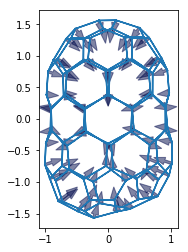

In [9]:
fig, ax = plot_forces(sheet, EllipsoidGeometry,
                      model, list('xz'), scaling=0.11)
ax.autoscale()

In [10]:
from tyssue.solvers.quasistatic import QSSolver
import logging
logger = logging.getLogger('tyssue.topology.sheet_topology')
logger.setLevel('INFO')
import sys

handler = logging.StreamHandler(sys.stdout)
logger.addHandler(handler)

solver = QSSolver(with_collisions=True, with_t1=True, with_t3=True)


In [11]:

res = solver.find_energy_min(sheet, EllipsoidGeometry, model)
print(res['message'])

b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


In [12]:
np.linalg.norm(model.compute_gradient(sheet))

0.004595512615484255

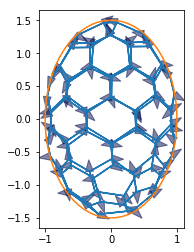

In [13]:
fig, ax = plot_forces(sheet, EllipsoidGeometry,
                      model, list('xz'), scaling=1e-4)
ax.autoscale()
ts = np.linspace(0, 2*np.pi, 100)
a, b, c = sheet.settings['abc']
ax.plot(a*np.cos(ts), c*np.sin(ts))

In [14]:
fig, meshes = sheet_view(sheet, mode='3D')
fig

Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

In [15]:
%pdb

Automatic pdb calling has been turned ON


In [62]:
from tyssue.generation import ellipsoid_sheet
abc = 85, 85, 150
sheet = ellipsoid_sheet(*abc, 30, phase_err=1e-2, pos_err=1e-2)
print(sheet.Nf)

920


In [106]:
A0 = sheet.face_df.area.mean()/1.2

sheet.vert_df['ellipsoid_constraint'] = 200.
sheet.face_df['prefered_area'] = A0
sheet.face_df['area_elasticity'] = 1.

sheet.edge_df['line_tension'] = 0.6 * A0**3/2
sheet.face_df['contractility'] = 0.02 * A0

EllipsoidGeometry.update_all(sheet)

model = model_factory([
    effectors.LineTension,
    effectors.FaceContractility,
    effectors.FaceAreaElasticity], effectors.FaceAreaElasticity)


In [96]:
sheet.settings['threshold_length'] = 1e-3


In [105]:
model.compute_gradient(sheet).head()

,gx,gy,gz
srce,,,
0,-57601.190443,-293893.070734,-49546.850294
1,-275709.622156,137350.859697,309944.552905
2,-16541.058564,-406634.720563,210981.580848
3,-33867.864287,-297174.803541,121083.838234
4,-57719.087769,387399.524928,-224165.985454


In [107]:

solver = QSSolver(with_collisions=False, with_t1=True, with_t3=True)

res = solver.find_energy_min(sheet, EllipsoidGeometry, model)
print(res['message'])


b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


In [61]:
ipv.clear()
fig, meshes = sheet_view(
    sheet,
    mode='3D',
    face={'visible':False,
          'color': sheet.face_df.area,})
fig

Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

In [56]:
from dataclasses import dataclass
from scipy.optimize import check_grad, minimize, approx_fprime
from tyssue.generation.shapes import get_ellipsoid_centers
from tyssue.generation import hexa_grid2d
from scipy.spatial import cKDTree
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

import xarray as xr

@dataclass
class ConstrainedPoints:
    '''Class for point-point computation'''
    
    abc: tuple
    lagrange: float = 10.0
    eq_dist: float = None
    neighbors: int = 6
    
    def reset_neighbors(self, points):
        
        self.points = points
        self.tree = cKDTree(self.points)
        neighbors = range(2, self.neighbors+2)
        _, self.indices = self.tree.query(
            self.tree.data, neighbors,
            eps=1e-1, n_jobs=-1)
    
    def update(self, points):
        
        a, b, c = self.abc
        self.points = points
        self.Np = points.shape[0]
        if self.eq_dist is None:
            self.eq_dist = 2 * c / np.sqrt(self.Np)
        self.rho2 = ((points / np.array([[a, b, c]]))**2).sum(axis=1)- 1
        self.drs = self.points[self.indices] - self.points[:, None, :]
        self.distances = np.linalg.norm(self.drs, axis=2)
        

        
    def energy(self):
        ellipsoid = 0# (self.lagrange * self.rho2**2)
        springs =(0.5*(self.distances - self.eq_dist)**2).sum(axis=1)
        return (springs + ellipsoid).sum()
    
    def gradient(self):
        edge_grad = -self.drs * (1 - self.eq_dist / self.distances[:, :, None])
        grad_elastic = edge_grad.sum(axis=1)
        trgt_grad = -xr.DataArray(
            edge_grad.reshape((-1, 3)),
            coords={'index':self.indices.ravel(),
            'pos': ['x', 'y', 'z']},
            dims=['index', 'pos']).groupby('index').sum(axis=0).sortby('index').values
        grad_elastic = grad_elastic - trgt_grad
        #a, b, c = self.abc
        #grad_ellipsis = 4*self.lagrange * self.rho2[:, None] * self.points /(np.array([[a, b, c]]))**2
        return grad_elastic # + grad_ellipsis
        
        
def cost_func(flat_pos, cp):
    cp.update(flat_pos.reshape((-1, 3)))
    return cp.energy()

def grad_func(flat_pos, cp):
    return cp.gradient().ravel()


$\theta$

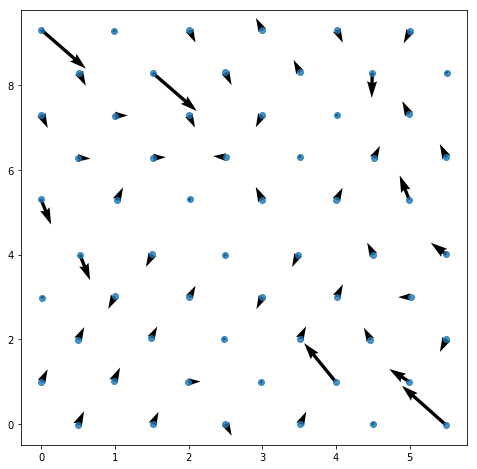

In [85]:
abc = (85, 85, 150)
points = get_ellipsoid_centers(*abc, 11, pos_err=1e-1)[['x', 'y', 'z']].values

points = np.zeros((60, 3))
points[:, :2] = hexa_grid2d(6, 10, 1, 1, noise=0.01)
points[30:, 1] += 0.3

#points = np.array([[0, 1, 0], [1, 1, 0], [0, 2, 0], [1, 2, 0]])


cp = ConstrainedPoints(abc, lagrange=0, eq_dist=0.8, neighbors=3)
cp.reset_neighbors(points)
cp.update(points)

fig, ax = plt.subplots()
ax.plot(points[:, 0], points[:, 1], 'o', alpha=0.8)
ax.quiver(*cp.points.T[:2], *-cp.gradient().T[:2], scale=10)
fig.set_size_inches(8, 8)

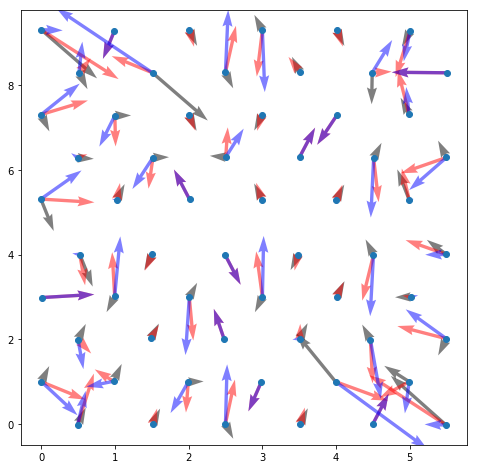

In [86]:
approx_grad = approx_fprime(cp.points.ravel(), cost_func, 1e-6, cp).reshape((-1, 3))

approx_grad[:3]

cp.gradient()[:3]

(check_grad(cost_func, grad_func, cp.points.ravel(), cp, epsilon=1e-8)
    / (cp.Np*np.linalg.norm(cp.gradient(), axis=1).mean()))


fig, ax = plt.subplots()
ax.plot(cp.points[:, 0], cp.points[:, 1], 'o')
ax.quiver(*cp.points.T[:2], *-cp.gradient().T[:2], scale=8, alpha=0.5)
ax.quiver(*cp.points.T[:2], *-approx_grad.T[:2], scale=8, color='r', alpha=0.5)
ax.quiver(*cp.points.T[:2], *-(approx_grad.T[:2] - cp.gradient().T[:2]), color='b', scale=8, alpha=0.5)

fig.set_size_inches(8, 8)

In [349]:
from tyssue import BulkGeometry, Epithelium
from tyssue.generation import from_3d_voronoi, single_cell
from scipy.spatial import Voronoi


def ellipsoid_sheet(a, b, c, n_zs, centers=None, **kwargs):
    """Creates an ellipsoidal apical mesh.

    Parameters
    ----------
    a, b, c : floats
       Size of the ellipsoid half axes in
       the x, y, and z directions, respectively
    n_zs : int
       The (approximate) number of faces along the z axis.

    kwargs are passed to `get_ellipsoid_centers`

    Returns
    -------
    eptm : a :class:`Epithelium` object

    The mesh returned is an `Epithelium` and not a simpler `Sheet`
    so that a unique cell data can hold information on the
    whole volume of the ellipsoid.

    """
    if centers is None:
        centers = get_ellipsoid_centers(a, b, c, n_zs, **kwargs)

    centers = centers.append(
        pd.Series({"x": 0, "y": 0, "z": 0, "theta": 0, "phi": 0}), ignore_index=True
    )

    centers["x"] /= a
    centers["y"] /= b
    centers["z"] /= c

    vor3d = Voronoi(centers[list("xyz")].values)
    vor3d.close()
    dsets = from_3d_voronoi(vor3d)
    veptm = Epithelium("v", dsets, config.geometry.bulk_spec())
    eptm = single_cell(veptm, centers.shape[0] - 1)

    eptm.vert_df["rho"] = np.linalg.norm(eptm.vert_df[eptm.coords], axis=1)
    eptm.vert_df["theta"] = np.arcsin(eptm.vert_df.eval("z/rho"))
    eptm.vert_df["phi"] = np.arctan2(eptm.vert_df["y"], eptm.vert_df["x"])

    eptm.vert_df["x"] = a * (
        np.cos(eptm.vert_df["theta"]) * np.cos(eptm.vert_df["phi"])
    )
    eptm.vert_df["y"] = b * (
        np.cos(eptm.vert_df["theta"]) * np.sin(eptm.vert_df["phi"])
    )
    eptm.vert_df["z"] = c * np.sin(eptm.vert_df["theta"])
    eptm.settings["abc"] = [a, b, c]
    BulkGeometry.update_all(eptm)
    return eptm


new = pd.DataFrame(res['x'].reshape((-1, 3)), columns=['x', 'y', 'z'])

sheet = ellipsoid_sheet(*abc, n_zs=5, centers=new)

ipv.clear()
fig, mesh = sheet_view(sheet, mode='3D')
fig

Figure(camera=PerspectiveCamera(fov=46.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

In [199]:
points.shape

(242, 3)